<a href="https://colab.research.google.com/github/le2363/STAT5243/blob/main/Project1/doc/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install anndata
!pip install 'scanpy[leiden]'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import scanpy as sc
adata = sc.read_h5ad('/content/drive/MyDrive/semester 8/STAT5243/cleaned_processed_frogtail.h5ad')

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata.X

<13199x31535 sparse matrix of type '<class 'numpy.int64'>'
	with 29297098 stored elements in Compressed Sparse Row format>

In [6]:
adata.obs.head()

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3


In [7]:
adata.X

<13199x31535 sparse matrix of type '<class 'numpy.int64'>'
	with 29297098 stored elements in Compressed Sparse Row format>

In [8]:
adata.X.toarray()[:5, :20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

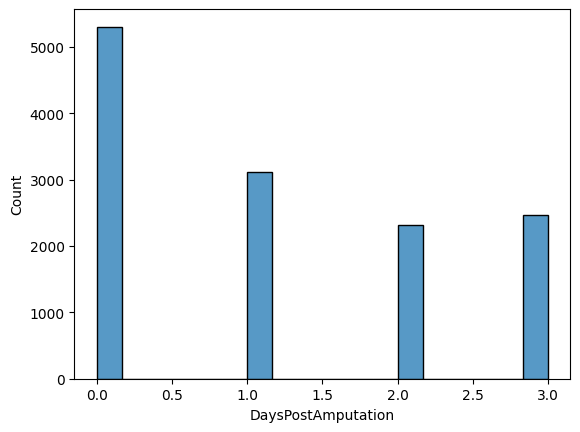

In [9]:
import seaborn as sns
sns.histplot(adata.obs['DaysPostAmputation'])

In [10]:
adata = adata[adata.obs['DaysPostAmputation'] == 0] # Subset on the time point 0
adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer

<ipython-input-10-88f00e64bca0>:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer


In [11]:
hvg_adata = sc.pp.log1p(adata, copy=True) # Log-normalize the data
sc.pp.highly_variable_genes(hvg_adata, n_top_genes=2000) # Select highly variable genes

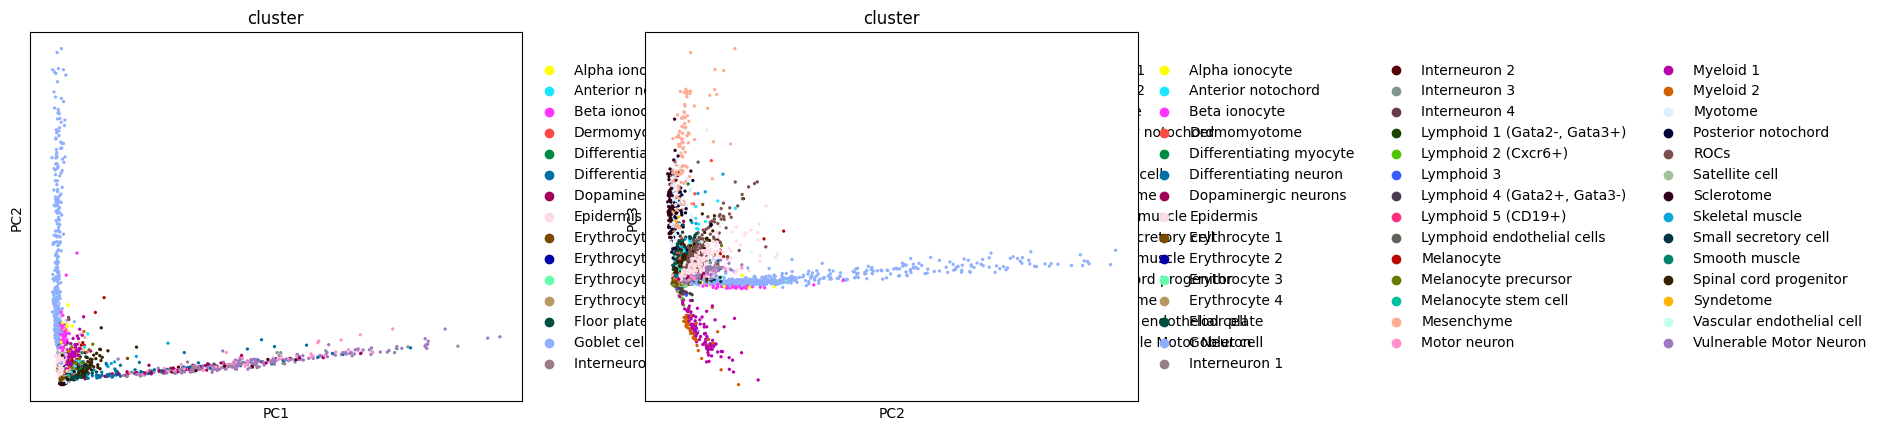

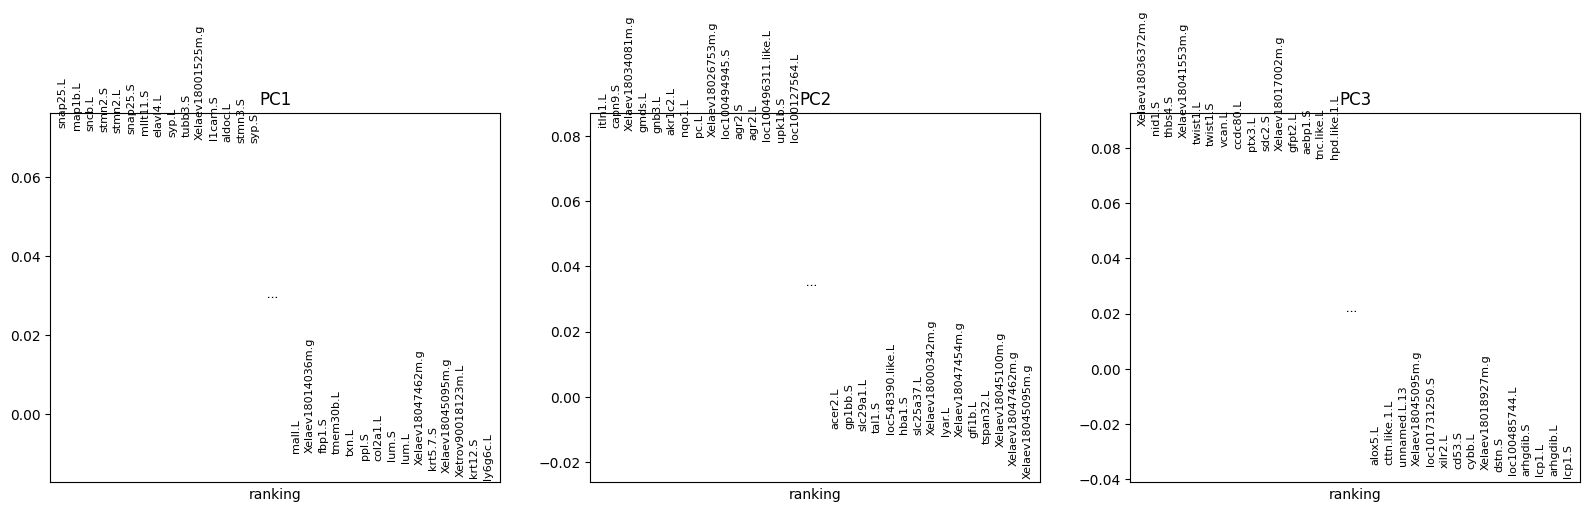

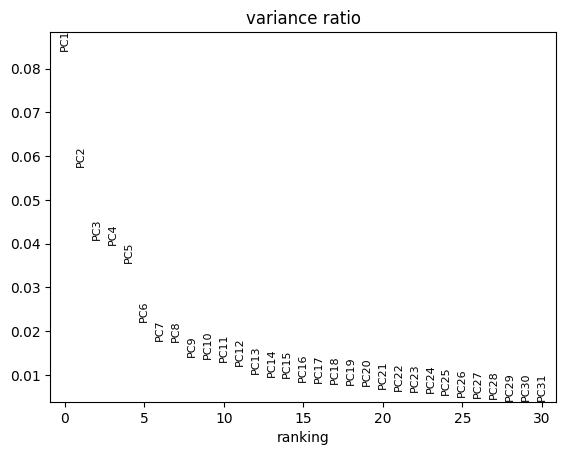

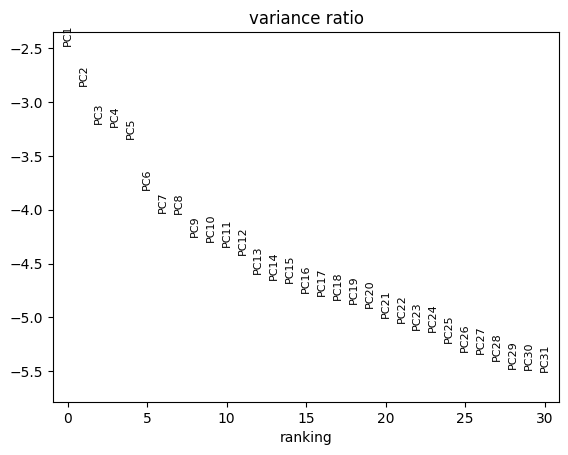

In [12]:
sc.pp.scale(hvg_adata) # Scale data

# Do PCA on the highly variable genes data - you might need to lognormalize to select HVG
sc.tl.pca(hvg_adata)
sc.pp.pca(hvg_adata)

sc.pl.pca_overview(hvg_adata, color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
sc.pl.pca_variance_ratio(hvg_adata, log=True)  # Use hvg_adata instead of adata

In [13]:
# Whitening step - create neighbors graph based on PCA
sc.pp.neighbors(hvg_adata, n_pcs=7) # Create neighbors graph - n_pcs takes the number of principal components from PCA you keep for this step
sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter

<ipython-input-13-0291f543527e>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter


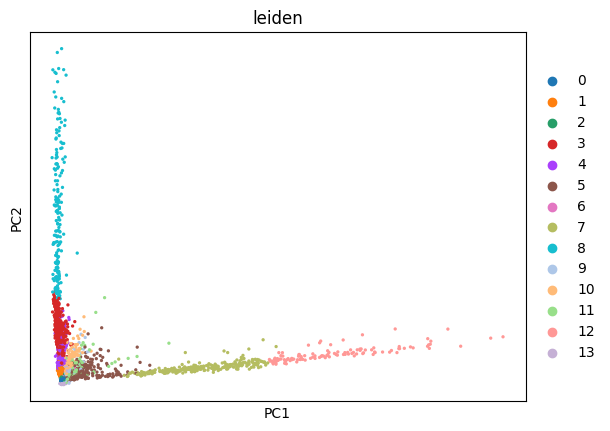

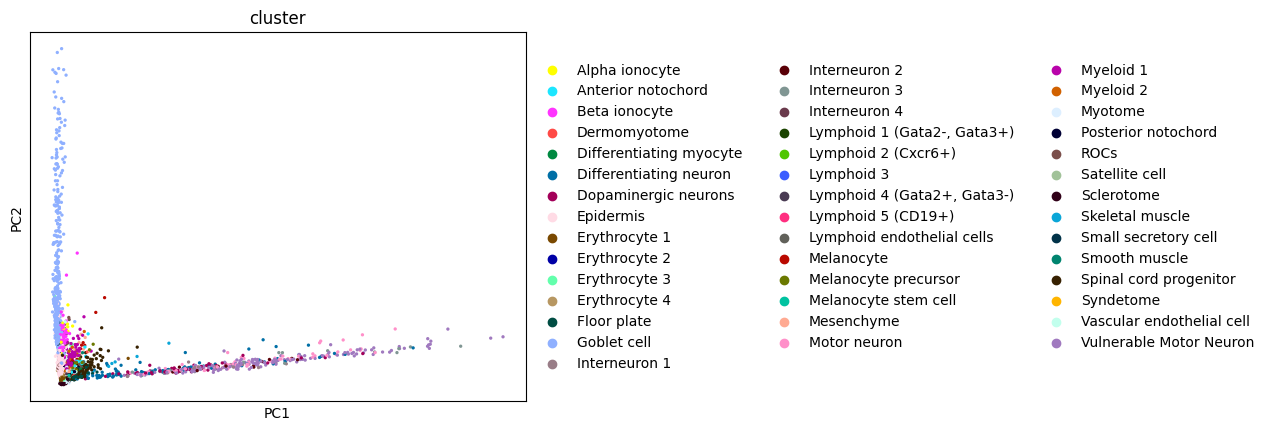

In [14]:
sc.pl.pca(hvg_adata, color=['leiden']) # Plotting PC1/PC2 with colors from Leiden labels
sc.pl.pca(hvg_adata, color=['cluster']) # Plotting PC1/PC2 with colors from original paper cluster

In [15]:
# Top 10 highly variable genes
hvg_genes = hvg_adata.var.highly_variable.sort_values(ascending=False).index[:10]

# Top 10 genes with highest mean expression
mean_genes = hvg_adata.X.mean(axis=0).argsort()[-10:][::-1]

# Top 10 most informative genes (variance-based)
variance_genes = hvg_adata.var['highly_variable'].sort_values(ascending=False).index[:10]

# 10 random genes
import numpy as np
random_genes = np.random.choice(hvg_adata.var_names, 10, replace=False)


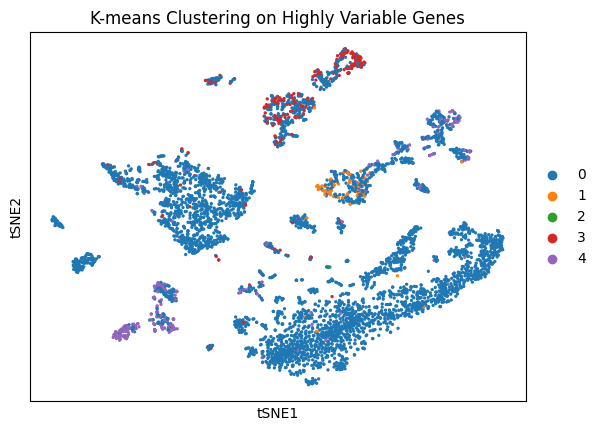

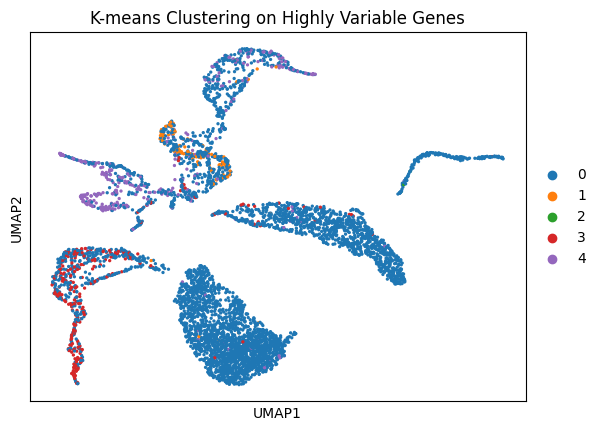

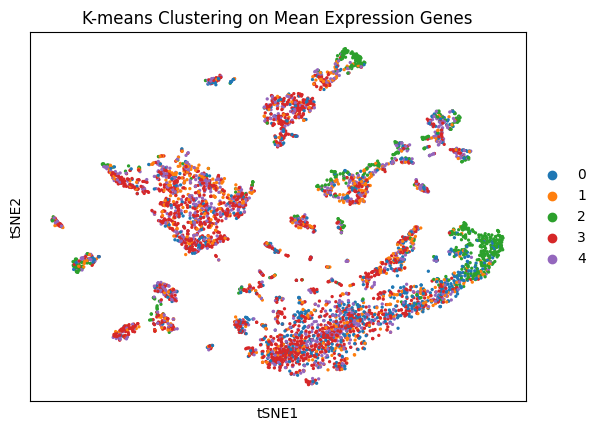

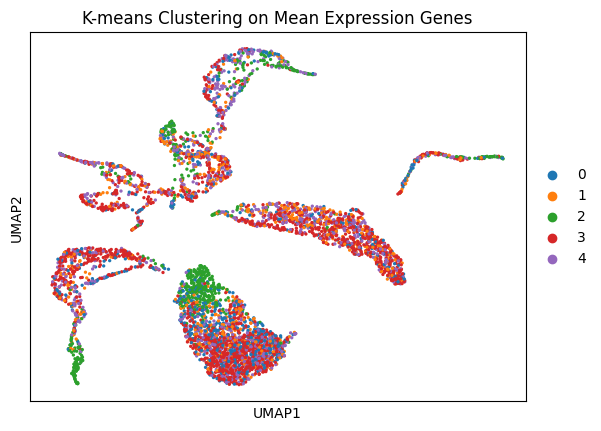

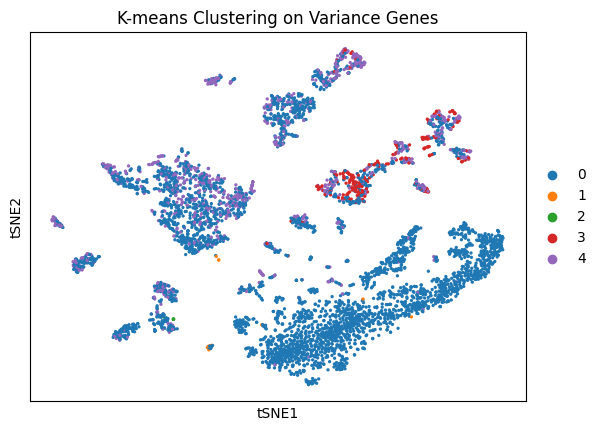

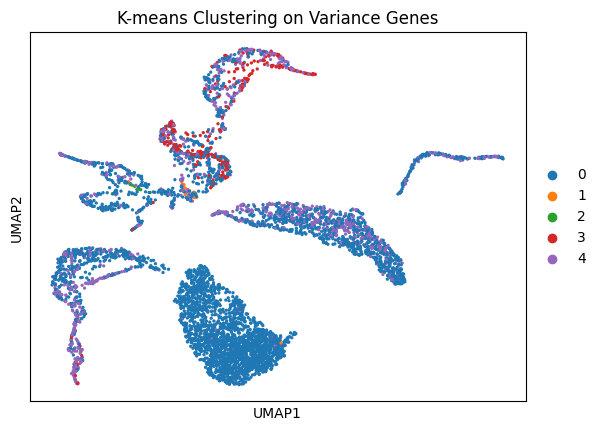

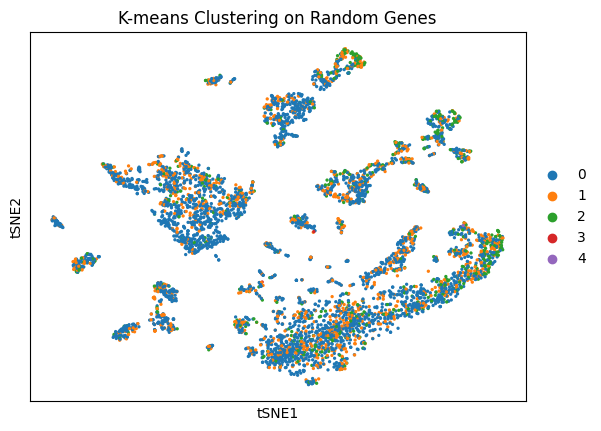

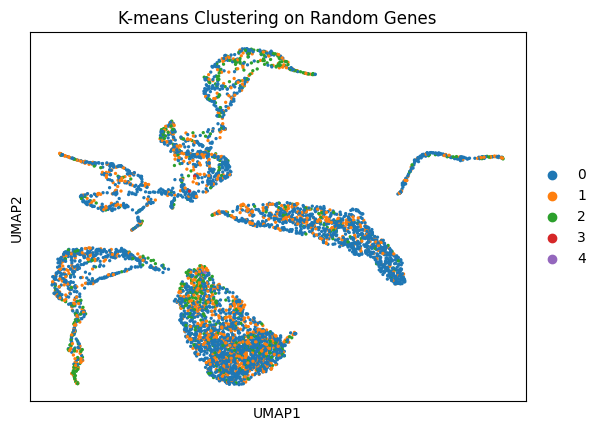

In [16]:
from sklearn.cluster import KMeans

# Function to apply K-means clustering on gene sets
def apply_kmeans(gene_set, K=5):
    kmeans = KMeans(n_clusters=K)
    # Fit the K-means model and return cluster labels
    return kmeans.fit_predict(hvg_adata[:, gene_set].X)

# Apply K-means clustering to each gene set
for i, gene_set in enumerate([hvg_genes, mean_genes, variance_genes, random_genes]):
    # Run K-means clustering
    cluster_labels = apply_kmeans(gene_set)

    # Store cluster labels in adata.obs with a unique column name for each iteration
    hvg_adata.obs[f'kmeans_{i}'] = cluster_labels.astype(str)  # Convert to string for coloring

    # Compute t-SNE and UMAP for visualization
    sc.tl.tsne(hvg_adata)
    sc.pl.tsne(hvg_adata, color=f'kmeans_{i}', title=f'K-means Clustering on {["Highly Variable", "Mean Expression", "Variance", "Random"][i]} Genes')

    sc.tl.umap(hvg_adata)
    sc.pl.umap(hvg_adata, color=f'kmeans_{i}', title=f'K-means Clustering on {["Highly Variable", "Mean Expression", "Variance", "Random"][i]} Genes')

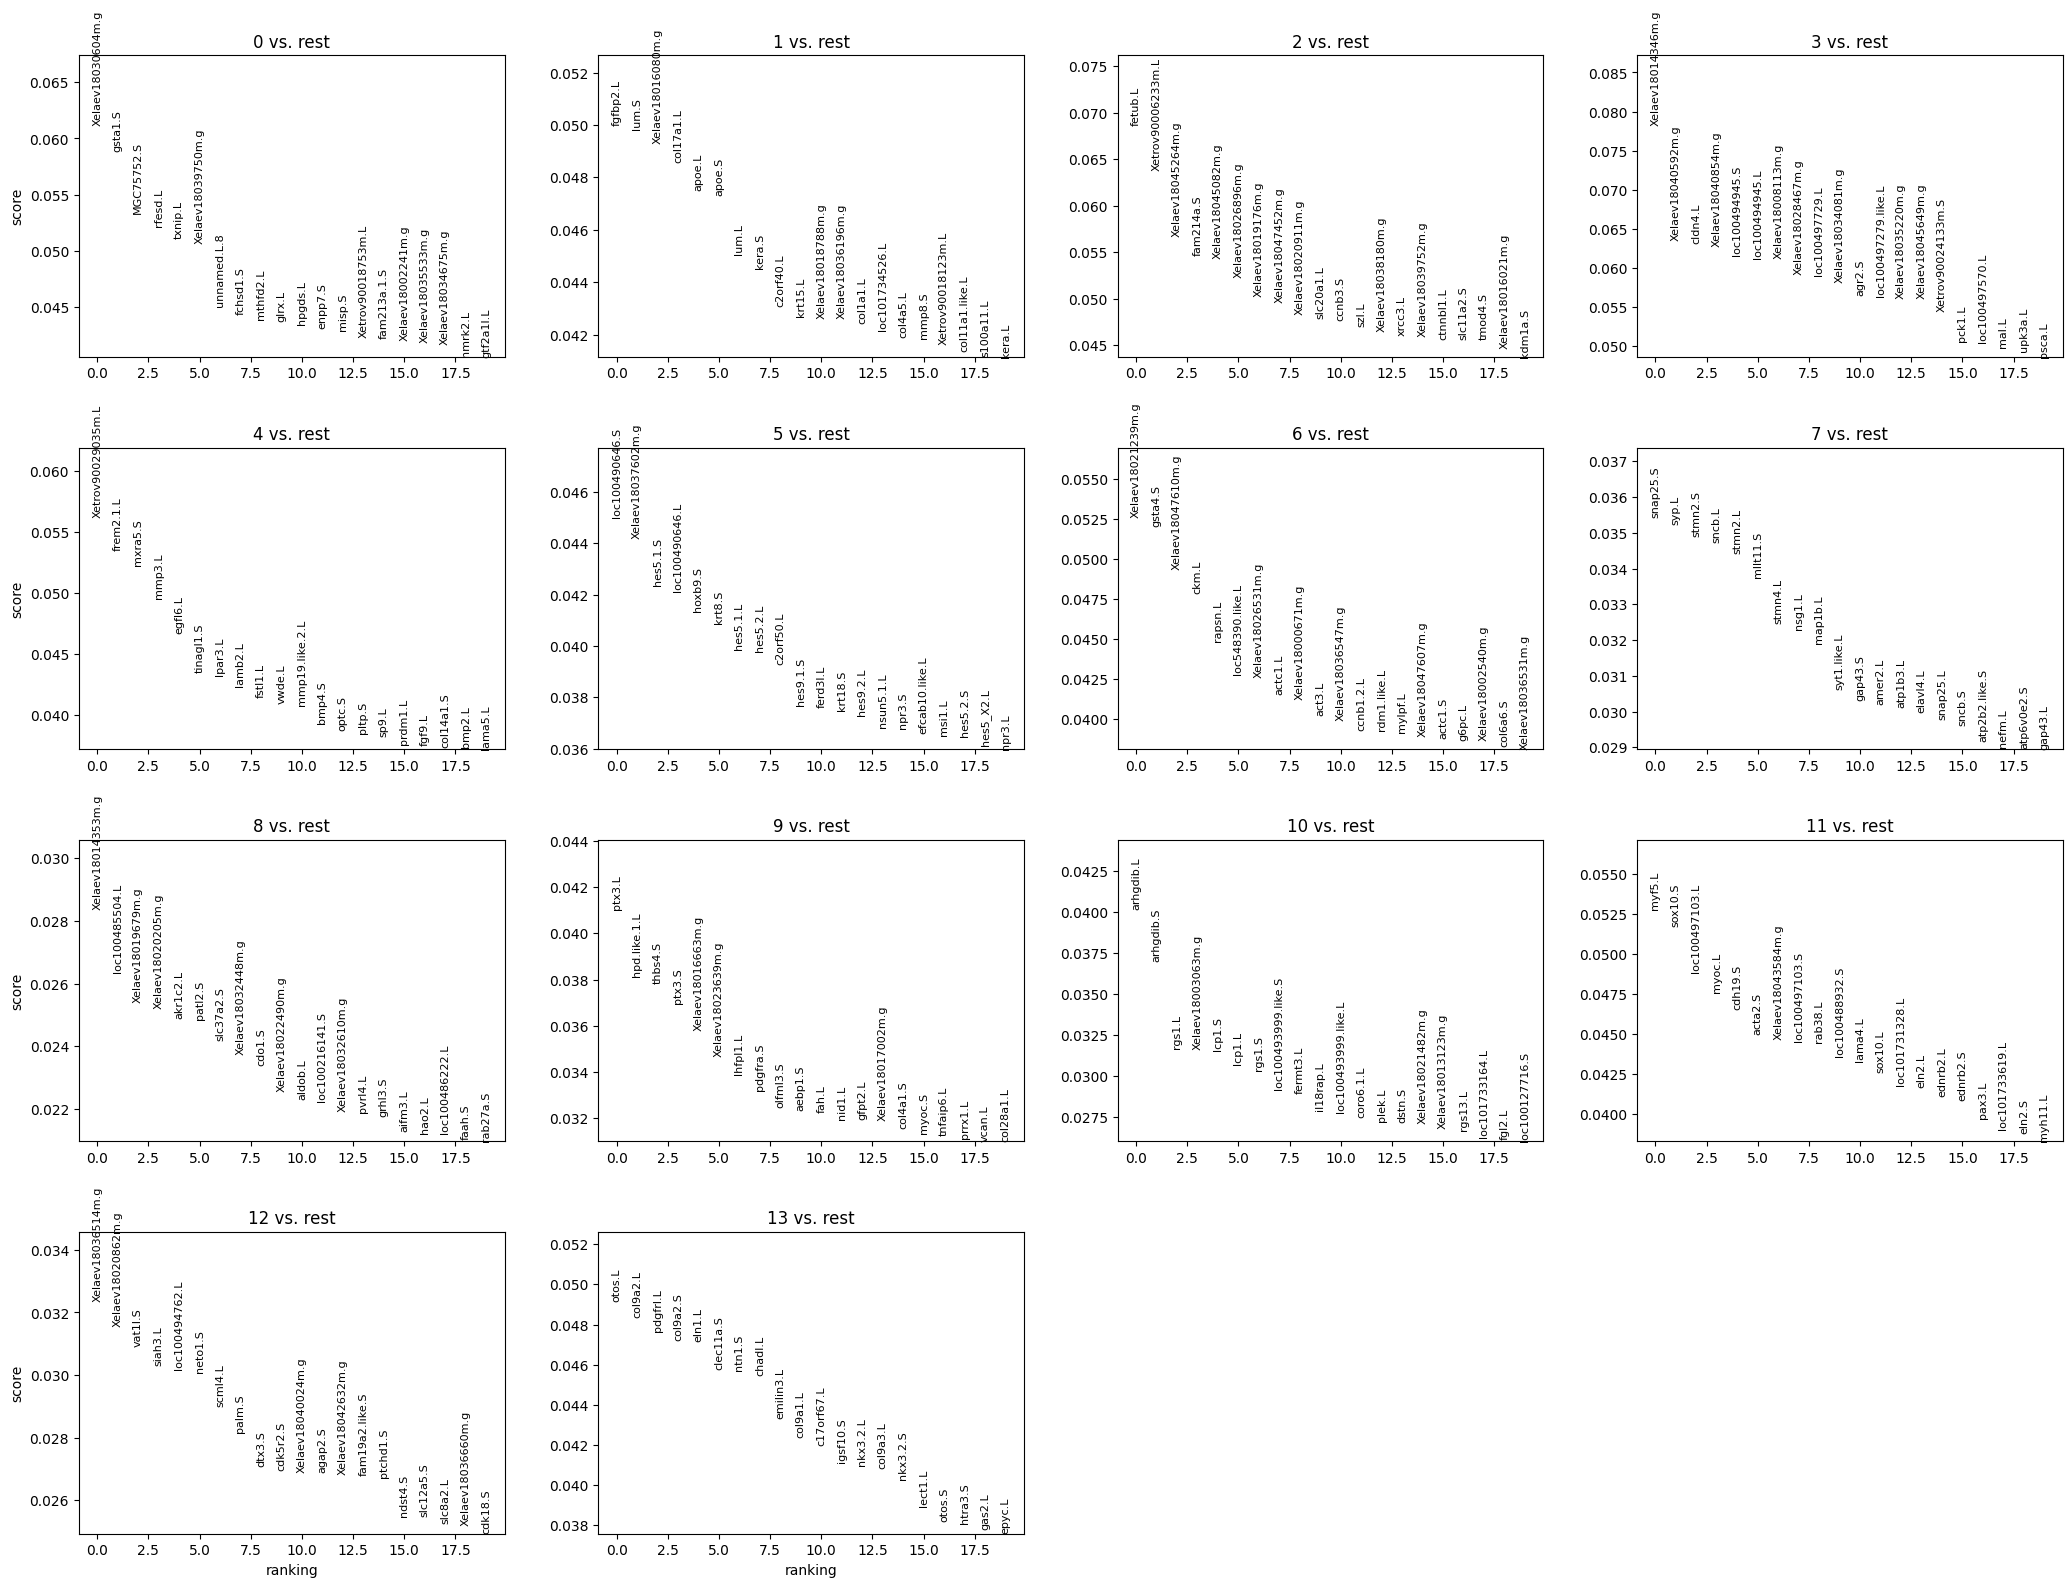

In [ ]:
# Visualize the top marker genes as a horizontal bar plot
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, groupby='leiden', title='Top Marker Genes', sharey=False)

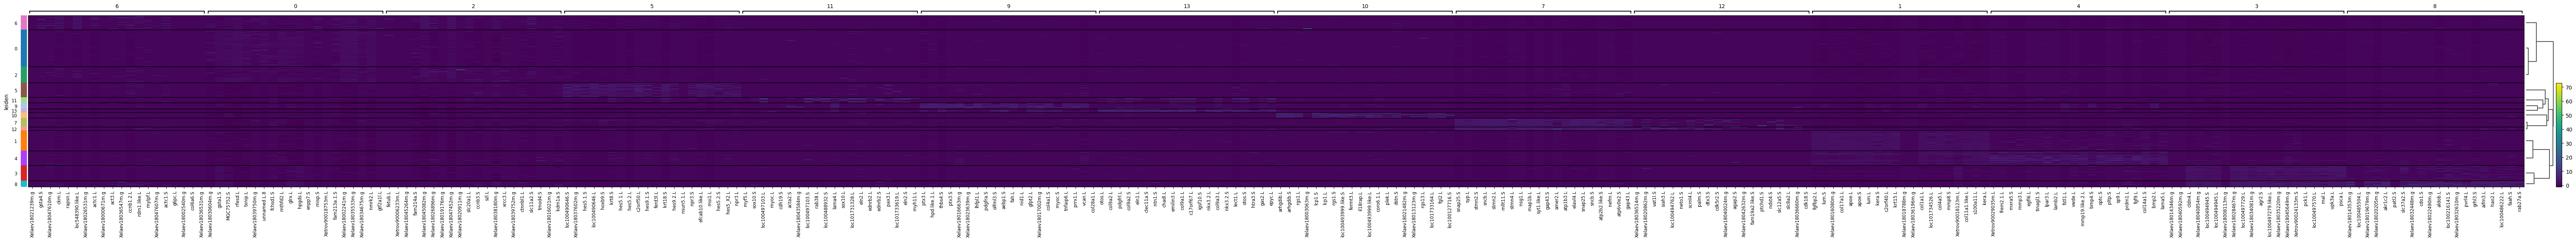

In [ ]:
# Visualizing the expression of the top marker genes
sc.pl.rank_genes_groups_heatmap(hvg_adata, n_genes=20, groupby='leiden', cmap='viridis', show_gene_labels=True)


In [ ]:
# Get the marker genes identified by rank_genes_groups
marker_genes = hvg_adata.uns['rank_genes_groups']['names']

# Display the top marker genes for each cluster
print(marker_genes)

[('Xelaev18030604m.g', 'fgfbp2.L', 'fetub.L', 'Xelaev18014346m.g', 'Xetrov90029035m.L', 'loc100490646.S', 'Xelaev18021239m.g', 'snap25.S', 'Xelaev18014353m.g', 'ptx3.L', 'arhgdib.L', 'myf5.L', 'Xelaev18036514m.g', 'otos.L')
 ('gsta1.S', 'lum.S', 'Xetrov90006233m.L', 'Xelaev18040592m.g', 'frem2.1.L', 'Xelaev18037602m.g', 'gsta4.S', 'syp.L', 'loc100485504.L', 'hpd.like.1.L', 'arhgdib.S', 'sox10.S', 'Xelaev18020862m.g', 'col9a2.L')
 ('MGC75752.S', 'Xelaev18016080m.g', 'Xelaev18045264m.g', 'cldn4.L', 'mxra5.S', 'hes5.1.S', 'Xelaev18047610m.g', 'stmn2.S', 'Xelaev18019679m.g', 'thbs4.S', 'rgs1.L', 'loc100497103.L', 'vat1l.S', 'pdgfrl.L')
 ('rfesd.L', 'col17a1.L', 'fam214a.S', 'Xelaev18040854m.g', 'mmp3.L', 'loc100490646.L', 'ckm.L', 'sncb.L', 'Xelaev18020205m.g', 'ptx3.S', 'Xelaev18003063m.g', 'myoc.L', 'siah3.L', 'col9a2.S')
 ('txnip.L', 'apoe.L', 'Xelaev18045082m.g', 'loc100494945.S', 'egfl6.L', 'hoxb9.S', 'rapsn.L', 'stmn2.L', 'akr1c2.L', 'Xelaev18016663m.g', 'lcp1.S', 'cdh19.S', 'loc1004

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


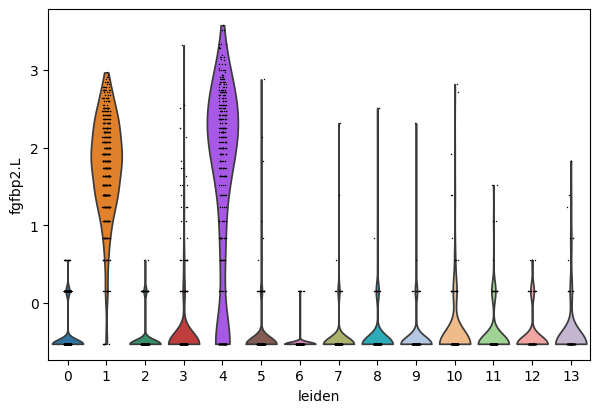

In [19]:
marker_gene = 'fgfbp2.L'

import matplotlib.pyplot as plt

# Visualize the expression of the selected marker gene across clusters
sc.pl.violin(hvg_adata, marker_gene, groupby='leiden')

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


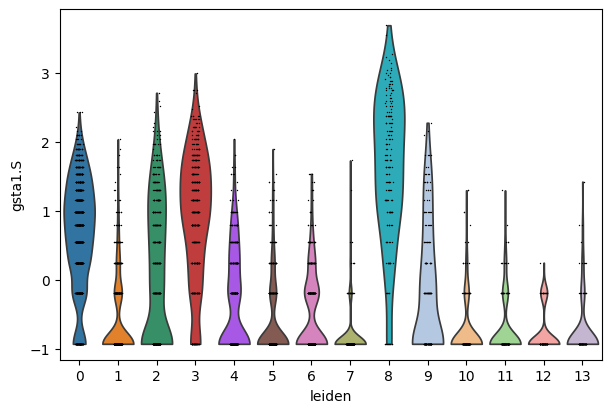

In [20]:
marker_gene = 'gsta1.S'

import matplotlib.pyplot as plt

# Visualize the expression of the selected marker gene across clusters
sc.pl.violin(hvg_adata, marker_gene, groupby='leiden')

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


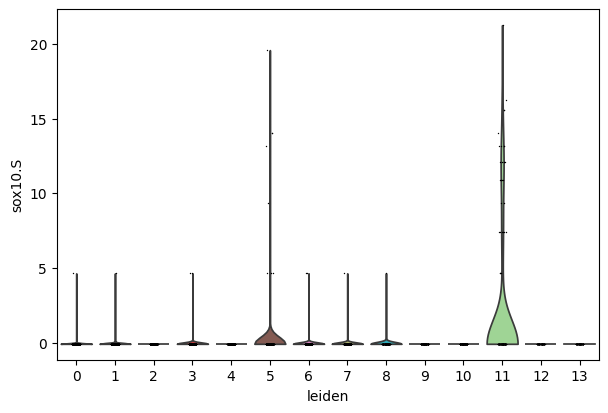

In [21]:
marker_gene = 'sox10.S'

import matplotlib.pyplot as plt

# Visualize the expression of the selected marker gene across clusters
sc.pl.violin(hvg_adata, marker_gene, groupby='leiden')